# Virtual Targets

To accompany the simulation models for the virtual power source different kinds of sinks were needed.
Most of them are pretty straight forward:

- resistive
- constant current
- constant power

More challenging was a simple LED with a current limiting resistor.

## Diode Target

Why? It's good for modeling a debug-diode that burns energy.
It uses the Shockley Diode Equation to estimate a model for diode

```
I_D = I_S * ( e ^ ( V_D / n*V_T ) - 1 )
```

with

In [13]:
import math

k = 1.380649e-23  # boltzmann
q = 1.6021766e-19  # elementary charge
TJ = 100 + 273.15  # junction temperature, estimation

V_T = k * TJ / q  # thermal voltage

# example LED
n = 2  # ideality factor
I_forward_A = 20e-3
V_forward_V = 2.0

# NOTE: math.expm1(x) = math.exp(x) - 1 = e^x -1
I_S = I_forward_A / math.expm1(V_forward_V / (V_T * n))  # scale current

The resistor in series can be added with

```
U_R = V_CC - V_D
I_R = U_R / R_Ohm
```

In [1]:
R_Ohm = 100

There is no simple direct formular to calculate the resulting current.
Instead, an iterative approach was chosen.
The formulas can be combined and rearranged.
Let's put it in a function and test it

In [15]:
from contextlib import suppress

V_CC = 5.0
V_D = 0 # starting point
for _ in range(10):
    V_D = V_T * n * math.log(1 + (V_CC - V_D) / (R_Ohm * I_S))
    I_R = (V_CC - V_D) / R_Ohm
    I_D = I_S * math.expm1(V_D / (V_T * n))
    print(f"I_R={I_R:6f} A, I_D={I_D:6f} A, V_D={V_D:3f} V")

I_R=0.029411 A, I_D=0.050000 A, V_D=2.058928 V
I_R=0.029752 A, I_D=0.029411 A, V_D=2.024800 V
I_R=0.029745 A, I_D=0.029752 A, V_D=2.025542 V
I_R=0.029745 A, I_D=0.029745 A, V_D=2.025526 V
I_R=0.029745 A, I_D=0.029745 A, V_D=2.025526 V
I_R=0.029745 A, I_D=0.029745 A, V_D=2.025526 V
I_R=0.029745 A, I_D=0.029745 A, V_D=2.025526 V
I_R=0.029745 A, I_D=0.029745 A, V_D=2.025526 V
I_R=0.029745 A, I_D=0.029745 A, V_D=2.025526 V
I_R=0.029745 A, I_D=0.029745 A, V_D=2.025526 V


This iteration converges fast. But it can be improved:

- give a better starting point for V_D
- stop iteration when error is low enough
- avoid log(0) errors and similar




In [16]:
from contextlib import suppress

V_CC = 5.0
V_D = V_CC / 2  # starting point
for _ in range(10):
    # low voltages tend to produce log(x<0)=err
    with suppress(ValueError):
        V_D = V_T * n * math.log(1 + (V_CC - V_D) / (R_Ohm * I_S))
    I_R = (V_CC - V_D) / R_Ohm
    I_D = I_S * math.expm1(V_D / (V_T * n))
    print(f"I_R={I_R:6f} A, I_D={I_D:6f} A, V_D={V_D:3f} V")
    if abs(I_R / I_D - 1) < 1e-6:
        break

I_R=0.029856 A, I_D=0.025000 A, V_D=2.014351 V
I_R=0.029742 A, I_D=0.029856 A, V_D=2.025768 V
I_R=0.029745 A, I_D=0.029742 A, V_D=2.025521 V
I_R=0.029745 A, I_D=0.029745 A, V_D=2.025526 V
I_R=0.029745 A, I_D=0.029745 A, V_D=2.025526 V


This approach works fine for certain voltage-ranges.
Let's try a lower voltage (0 < x < V_forward).

In [19]:
from contextlib import suppress

V_CC = 1.9
V_D = V_CC / 2  # starting point
for _ in range(10):
    # low voltages tend to produce log(x<0)=err
    with suppress(ValueError):
        V_D = V_T * n * math.log(1 + (V_CC - V_D) / (R_Ohm * I_S))
    I_R = (V_CC - V_D) / R_Ohm
    I_D = I_S * math.expm1(V_D / (V_T * n))
    print(f"I_R={I_R:6f} A, I_D={I_D:6f} A, V_D={V_D:3f} V")
    if abs(I_R / I_D - 1) < 1e-6:
        break

I_R=-0.000521 A, I_D=0.009500 A, V_D=1.952124 V
I_R=-0.000521 A, I_D=0.009500 A, V_D=1.952124 V
I_R=-0.000521 A, I_D=0.009500 A, V_D=1.952124 V
I_R=-0.000521 A, I_D=0.009500 A, V_D=1.952124 V
I_R=-0.000521 A, I_D=0.009500 A, V_D=1.952124 V
I_R=-0.000521 A, I_D=0.009500 A, V_D=1.952124 V
I_R=-0.000521 A, I_D=0.009500 A, V_D=1.952124 V
I_R=-0.000521 A, I_D=0.009500 A, V_D=1.952124 V
I_R=-0.000521 A, I_D=0.009500 A, V_D=1.952124 V
I_R=-0.000521 A, I_D=0.009500 A, V_D=1.952124 V


There is clearly something wrong! The determined diode voltage is bigger than V_CC and results in a negative resistor-current.
This can be avoided by adding some constraints:

- diode voltage can't be larger than V_CC
- currents can't be negative
- both currents should match -> so V_D is re-calculated by using the mean-current

In [29]:
def calc_current(V_CC: float) -> float:
    V_D = V_CC / 2  # starting point
    I_R = I_D = 0
    for _ in range(10):
        # low voltages tend to produce log(x<0)=err
        with suppress(ValueError):
            V_D = V_T * n * math.log(1 + (V_CC - V_D) / (R_Ohm * I_S))
        V_D = min(V_CC, V_D)
        I_R = max(0.0, (V_CC - V_D) / R_Ohm)
        I_D = max(0.0, I_S * math.expm1(V_D / (V_T * n)))
        # print(f"I_R={I_R:6f} A, I_D={I_D:6f} A, V_D={V_D:3f} V")
        if abs(I_R / I_D - 1) < 1e-6:
            break
        # take mean of both currents and determine a new V_D
        V_D = V_CC - R_Ohm * (I_R + I_D) / 2
    return (I_R + I_D) / 2

Text(0, 0.5, 'I_Diode [A]')

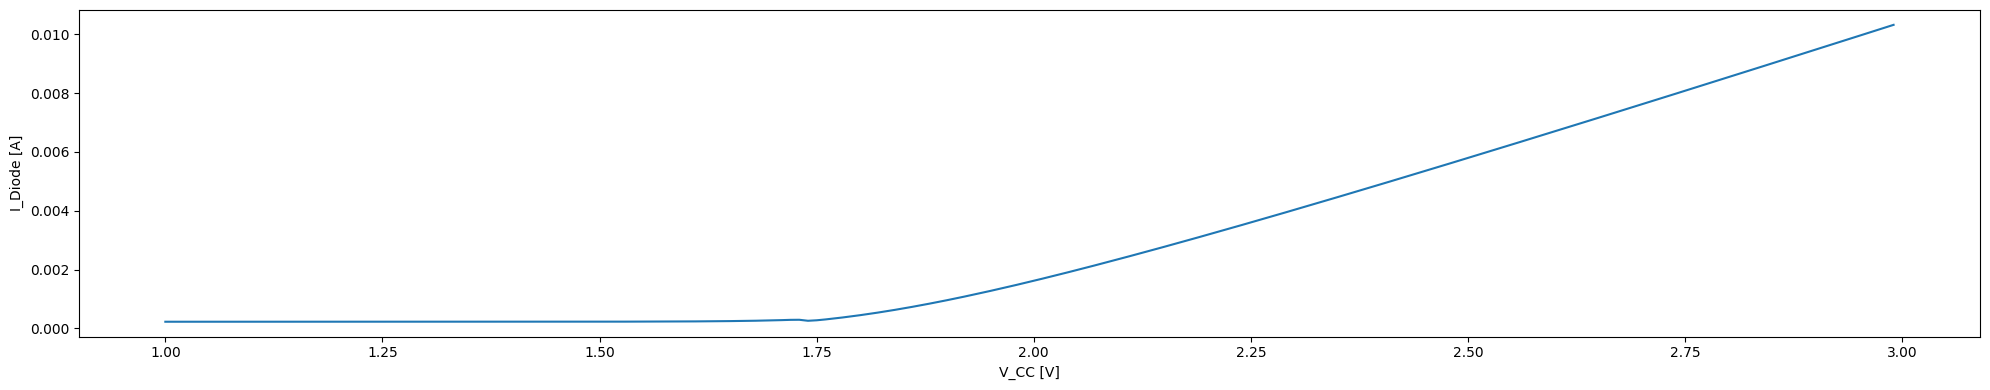

In [38]:
from matplotlib import pyplot as plt
R_Ohm = 100
vcc: list[float] = []
id: list[float] = []
for vcc_mV in range(1000, 3000, 10):
    V_CC = vcc_mV*1e-3
    vcc.append(V_CC)
    id.append(calc_current(V_CC))

fig = plt.figure(figsize=(20, 4), layout="tight")
plt.plot(vcc, id)
plt.xlabel("V_CC [V]")
plt.ylabel("I_Diode [A]")

The effect of the current limiting resistor is visible. Let's try it with a much lower resistor.

Text(0, 0.5, 'I_Diode [A]')

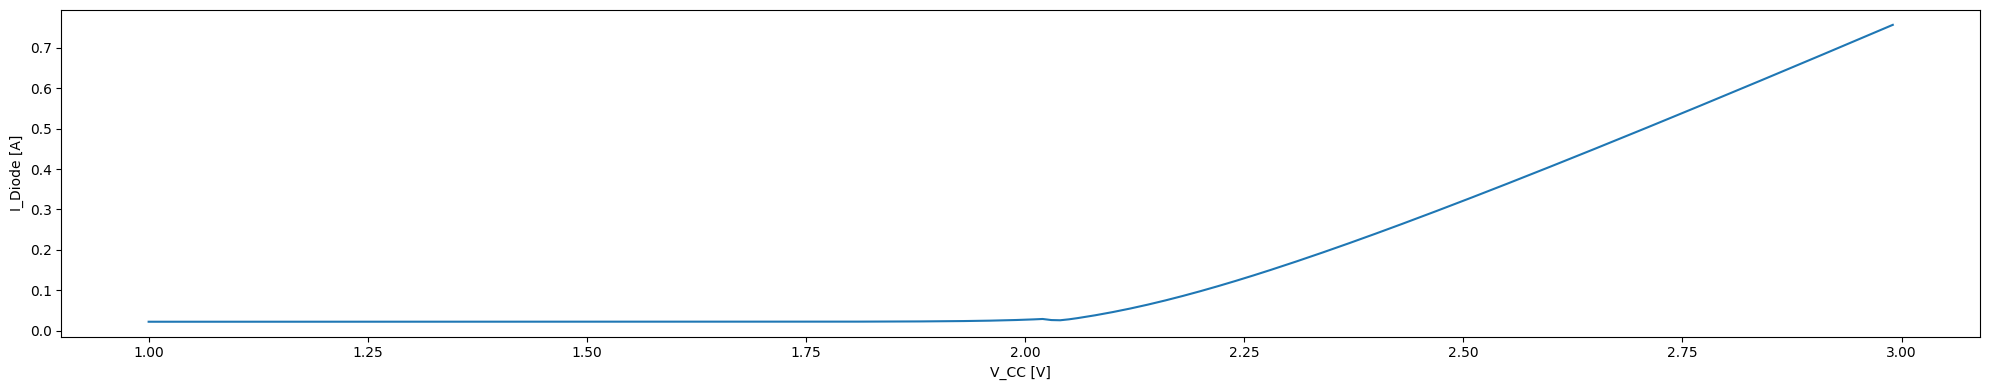

In [37]:
R_Ohm = 1
vcc: list[float] = []
id: list[float] = []
for vcc_mV in range(1000, 3000, 10):
    V_CC = vcc_mV*1e-3
    vcc.append(V_CC)
    id.append(calc_current(V_CC))

fig = plt.figure(figsize=(20, 4), layout="tight")
plt.plot(vcc, id)
plt.xlabel("V_CC [V]")
plt.ylabel("I_Diode [A]")